# Spectra

In [ ]:
#import packages
import numpy as np
import json 
import scanpy as sc
from collections import OrderedDict
import scipy 
import pandas as pd
import matplotlib.pyplot as plt

#spectra imports 
import Spectra as spc
from Spectra import Spectra_util as spc_tl
from Spectra import K_est as kst
from Spectra import default_gene_sets


In [9]:
adata = sc.read_10x_mtx('./RNA_data/')
df = pd.read_csv('./RNA_data/df_cell.csv',index_col = 0)
adata.obs['treament'] = df.cell_type
adata

AnnData object with n_obs × n_vars = 5952 × 25178
    obs: 'treament'
    var: 'gene_ids'

In [10]:
sc.pp.filter_genes(adata, min_cells=10)

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=False,
    # layer="counts",
    flavor="seurat_v3"
    )

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [29]:
# load the default gene set dictionary from the Spectra paper:
annotations = spc.default_gene_sets.load()
annotations = annotations['global']

In [30]:
annotations = spc_tl.check_gene_set_dictionary(
    adata,
    annotations,
    obs_key='treament',
    global_key='global',
    use_cell_types = False)

Cell type labels in gene set annotation dictionary and AnnData object are identical
Your gene set annotation dictionary is now correctly formatted.


In [34]:
adata

AnnData object with n_obs × n_vars = 5952 × 22131
    obs: 'treament'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'spectra_vocab'
    uns: 'hvg', 'log1p'

In [ ]:
#fit the model (We will run this with only 2 epochs to decrease runtime in this tutorial)
model_global = spc.est_spectra(adata = adata, gene_set_dictionary = annotations, 
                               # because we do not use the cell types
                               # we will supply a regular dict
                               # instead of the nested dict above
                        use_highly_variable = True, cell_type_key =None, #"cell_type_annotations" ,
                        use_weights = True, lam = 0.1, 
                        delta=0.001,kappa = 0.00001, rho = 0.00001, 
                        use_cell_types = False, #set to False to not use the cell type annotations
                        n_top_vals = 25, 
                        clean_gs=True,
                        label_factors=True,
                        num_epochs=10000  #for demonstration purposes we will only run 2 epochs, we recommend 10,000 epochs
                       )

In [ ]:
model_global.save('spectra_model')
adata.write_h5ad('./adata_learned_v1.h5ad')

In [ ]:
SPECTRA_cell_scores = adata.obsm['SPECTRA_cell_scores']

In [ ]:
gene_score_df = pd.DataFrame(SPECTRA_cell_scores, 
                             index=adata1scr.obs_names, 
                             columns=adata1scr.uns['SPECTRA_overlap'].index)

In [ ]:
gene_score_df.to_csv('./Spectra/df_gene_score.csv')

# evaluation

In [2]:
library(Seurat)
library(tidyverse)
library(cowplot)
library(DropletUtils)
library(clustree)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: 'SeuratObject'


The following object is masked from 'package:base':

    intersect


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.4.4     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'cowplot'


The following object is masked from 'package:lubridate':

    stamp


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: '

In [3]:
input_matrix = read.csv('./Spectra/df_gene_score.csv',row.names=1)
metadata<-readRDS('metadata.rds')
table(rownames(input_matrix) == rownames(metadata))


TRUE 
5952 

In [4]:
seurat_obj <- Seurat::CreateSeuratObject(counts = t(input_matrix))
seurat_obj@meta.data <- cbind(seurat_obj@meta.data, metadata[,4,drop=FALSE])
seurat_obj@assays$RNA$data = seurat_obj@assays$RNA$counts
seurat_obj@assays$RNA$scale.data = as.matrix(seurat_obj@assays$RNA$counts)


Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Data is of class matrix. Coercing to dgCMatrix."


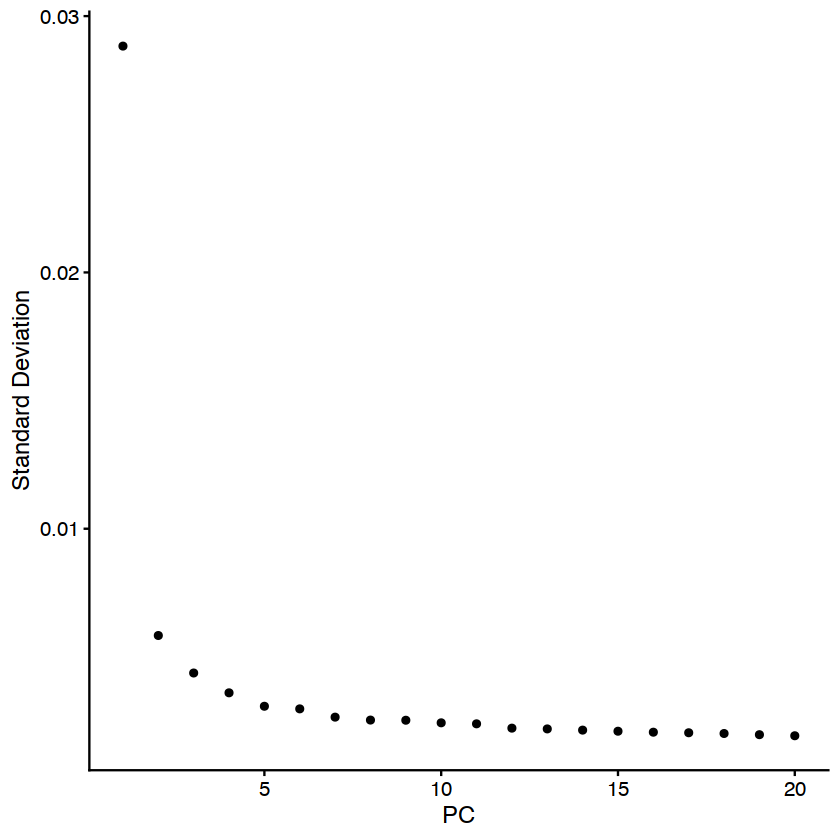

In [5]:
seurat_obj <- Seurat::RunPCA(object = seurat_obj, features = rownames(seurat_obj), seed.use = 1, verbose=FALSE)
ElbowPlot(seurat_obj)

Warning message in Seurat::JackStraw(seurat_obj, num.replicate = 10, dims = 30):
"Number of variable genes given 0.01 as the prop.freq is low. Consider including more variable genes and/or increasing prop.freq. Continuing with 3 genes in every random sampling."
Warning message:
"Removed 3755 rows containing missing values (`geom_point()`)."


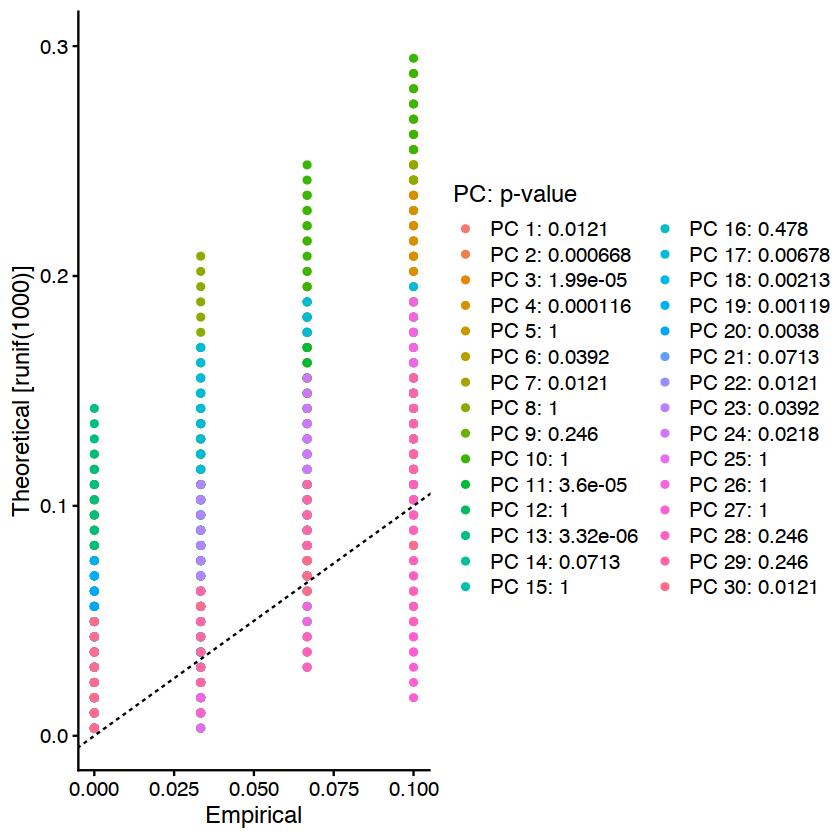

In [12]:
# perform JackStaw procedure and identify 'significant' PCs as those who have a strong enrichment of low p-value features. (https://satijalab.org/seurat/articles/pbmc3k_tutorial.html)
seurat_obj <- Seurat::JackStraw(seurat_obj, num.replicate = 10,dims = 30)
seurat_obj <- Seurat::ScoreJackStraw(seurat_obj, dims = 1:30)
Seurat::JackStrawPlot(seurat_obj, dims = 1:30)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
12:42:10 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

12:42:10 Read 5952 rows and found 20 numeric columns

12:42:10 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

12:42:10 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:42:10 Writing NN index file to t

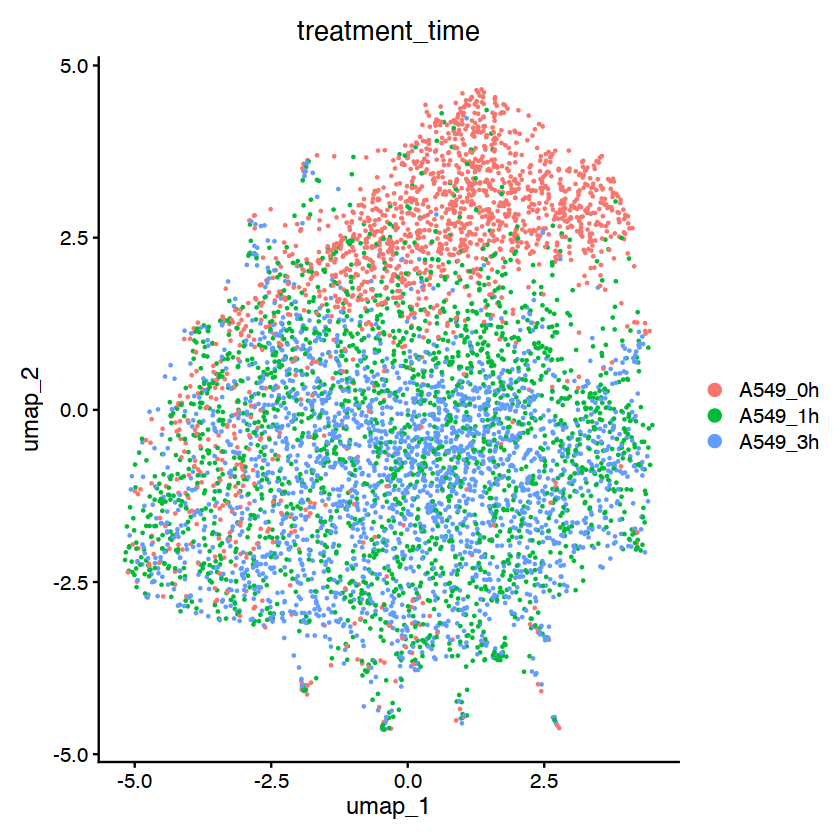

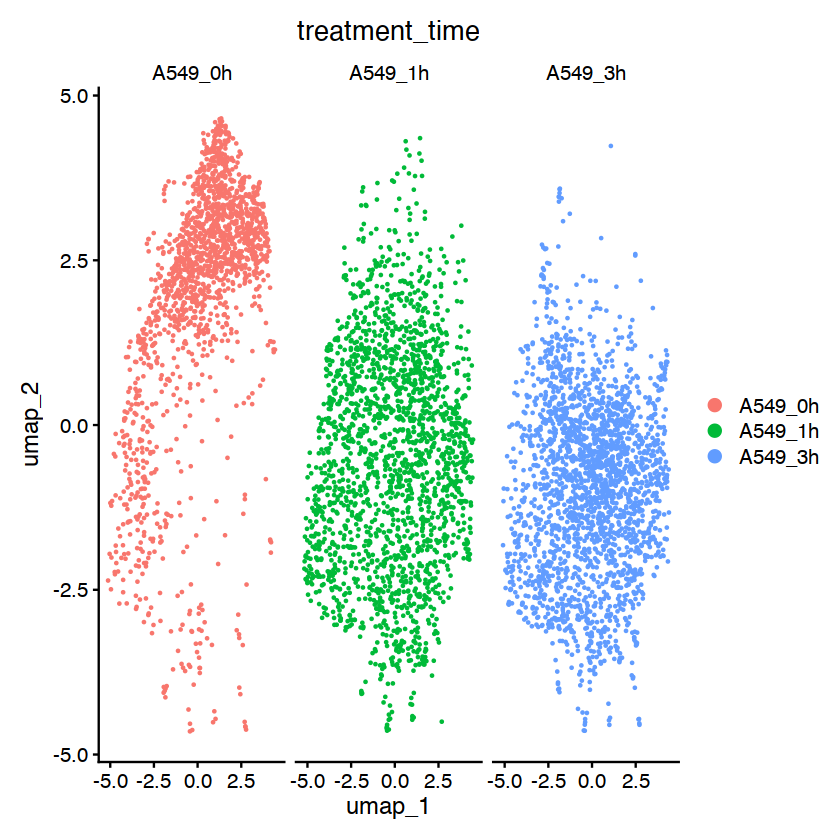

In [6]:
seurat_obj <- RunUMAP(seurat_obj, dims = 1:20)
DimPlot(seurat_obj, reduction = "umap",group.by = 'treatment_time')
DimPlot(seurat_obj, reduction = "umap",group.by = 'treatment_time',split.by = 'treatment_time')

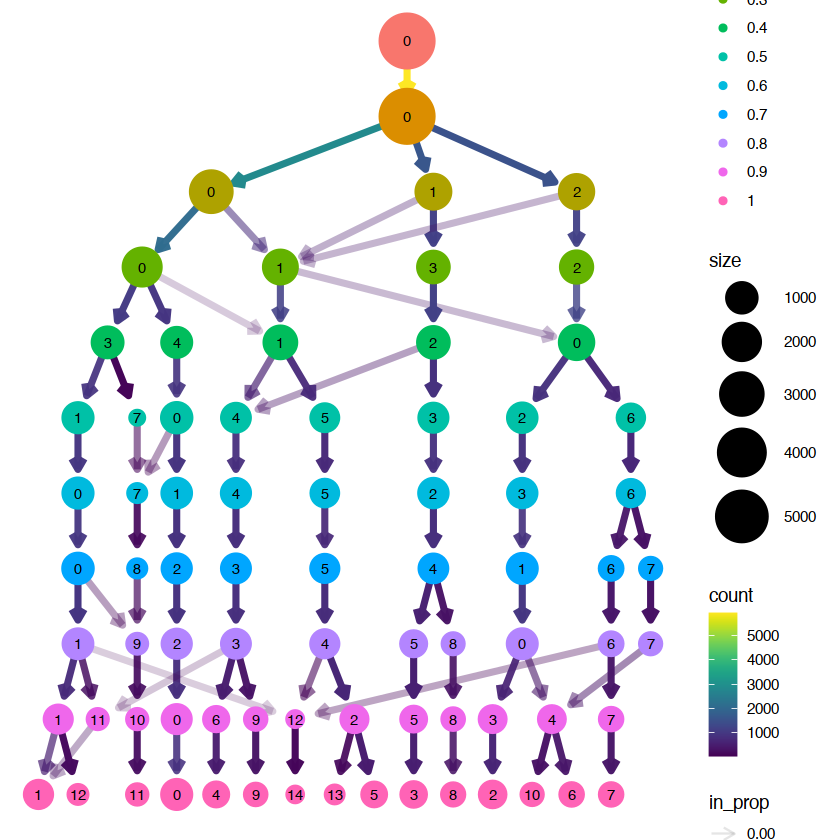

In [13]:
cluster_resolution <- seq(0,1,0.1)
n_pc = 13

seurat_obj <- Seurat::FindNeighbors(seurat_obj, reduction = "pca",  dims = 1:n_pc, verbose = FALSE)

for (resolution in cluster_resolution) {
  seurat_obj <- Seurat::FindClusters(seurat_obj, resolution = resolution, verbose = FALSE)
}

clustree::clustree(seurat_obj, prefix = "RNA_snn_res.")

In [16]:
aricode::ARI(seurat_obj$treatment_time,seurat_obj$RNA_snn_res.0.2)

[1] 0.2185672

In [17]:
aricode::AMI(seurat_obj$treatment_time,seurat_obj$RNA_snn_res.0.2)

[1] 0.2266121

In [18]:
saveRDS(seurat_obj,'./Spectra/Seurat.rds')

In [21]:
p<-DimPlot(seurat_obj, reduction = "umap",group.by = 'RNA_snn_res.0.2') + labs(title = '')
cowplot::save_plot('./Spectra/UAMP_cluster.png', p,
                   base_aspect_ratio = 1, base_height = 4)

seurat_obj$treatment <- substring(seurat_obj$treatment_time,6)

p<-DimPlot(seurat_obj, reduction = "umap",group.by = 'treatment') + labs(title = 'Treatment')
cowplot::save_plot('./Spectra/UAMP_treatment_time.png', p,
                   base_aspect_ratio = 1, base_height = 4)